In [1]:
# imports
import os
import sys

# code for enabling this notebook to work within cursor
coralme_dir = '/home/chris/zuniga/coralme/' #'../'
sys.path.insert(0, coralme_dir)

import cobra
import coralme
import coralme.solver.solver
import coralme.builder.main
import coralme.core.model
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

def get_n_colors_from_colormap(n, colormap_name='viridis'):
    cmap = cm.get_cmap(colormap_name)
    return [cmap(i / (n - 1)) for i in range(n)]
    
def create_m_to_me_mapping(m_model, me_model):
    """
    Create a dictionary mapping M model reaction IDs to their corresponding ME model reaction IDs
    
    Parameters:
    -----------
    m_model : cobra.Model
        Original M model
    me_model : coralme.core.MEModel
        ME model generated from M model
        
    Returns:
    --------
    dict
        Dictionary with M model reaction IDs as keys and lists of corresponding ME reaction IDs as values
    """
    m_to_me = {}
    
    # For each M model reaction, find corresponding ME reactions
    for m_rxn in m_model.reactions:
        # Find all ME reactions that contain this M reaction ID
        me_rxns = [me_rxn.id for me_rxn in me_model.reactions 
                  if m_rxn.id in me_rxn.id]
        
        if me_rxns:
            m_to_me[m_rxn.id] = me_rxns
            
    return m_to_me

In [2]:
# look for default starting media and annotate pathways
path = os.path.join(coralme_dir, 'data', 'default_model_exchanges.pkl')
if os.path.exists(path):
    pickle_in = open(path, 'rb')
    default_exchanges = pickle.load(pickle_in)
    pickle_in.close()
else:
    default_exchanges = {}

# create EC to pathway mapping
resp = requests.get('https://rest.kegg.jp/link/ec/pathway')
EC_to_pathways = {}
for line in resp.text.split('\n')[:-1]:
    if 'path:ec' in line: continue
    ec = line.split('\t')[1][3:]
    path = line.split('\t')[0][5:]
    if ec not in EC_to_pathways:
        EC_to_pathways.update({ec : set()})
    EC_to_pathways[ec].add(path)

# now create mapping from pathway to name
resp = requests.get('https://rest.kegg.jp/list/pathway')
pathway_to_name = {}
for line in resp.text.split('\n')[:-1]:
    pathway_to_name.update({line.split('\t')[0] : line.split('\t')[1]})

# loop through each model
spec_to_neg_EX = {}
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
for f in os.listdir(os.path.join(base_dir, 'individual_species')):
    if f == 'Reference': continue
        
    # load in ME_model
    out_path = os.path.join(base_dir, 'individual_species', f, 'outputs')
    if os.path.exists(os.path.join(out_path, 'pathway_annotated_model.pkl')):
        print(str(f)+' : pathway annotated model already created, skipping')
        continue
    out_dict = {}
    opts = os.listdir(out_path)
    model_name = None
    for opt in opts:
        if 'step3' in opt:
            model_name = opt
    if not model_name:
        print(str(f)+' : model doesn\'t exist')
        continue
    print(str(f)+' : loading model...', end = '')
    ME_model = coralme.io.pickle.load_pickle_me_model(os.path.join(out_path, model_name))
    model_path = os.path.join(base_dir, 'individual_species', f, 'inputs', 'model.json')
    M_model = cobra.io.load_json_model(model_path)
    
    # look through exchange reactions to figure out what the media type is
    print('finding media exchanges...', end = '')
    spec_to_neg_EX.update({f : set()})
    for rxn in ME_model.reactions:
        if 'EX_' not in rxn.id:
            continue
        elif rxn.lower_bound < 0:
            spec_to_neg_EX[f].add((rxn.id, rxn.lower_bound, rxn.upper_bound))

    # let's also create subsystem annotations in the ME model
    print('mapping pathways...', end = '')
    mapping = create_m_to_me_mapping(M_model, ME_model)
    for M_rxn, ME_rxns in mapping.items():
        if 'ec-code' not in M_model.reactions.get_by_id(M_rxn).annotation: continue
        pathways = set()
        for ec_code in M_model.reactions.get_by_id(M_rxn).annotation['ec-code']:
            if ec_code not in EC_to_pathways: continue
            pathways = pathways.union(EC_to_pathways[ec_code])
        pathways = list(pathways)
        pathways.sort()
        for rxn in ME_rxns:
            ME_model.reactions.get_by_id(rxn).annotation.update({'pathways' : pathways})

    # let's also pass along the GPR rules
    for M_rxn, ME_rxns in mapping.items():
        M_rxn = M_model.reactions.get_by_id(M_rxn)
        for ME_rxn in ME_rxns:
            ME_model.reactions.get_by_id(ME_rxn).annotation.update({'genes' : set(M_rxn.gpr.genes)})
        
    # now let's save the ME model with the annotations
    print('saving model...', end = '')
    coralme.io.pickle.save_pickle_me_model(ME_model, os.path.join(out_path, 'pathway_annotated_model.pkl'))
    print(' done!')

# save off changes
pickle_out = open(path, 'wb')
pickle.dump(default_exchanges, pickle_out)
pickle_out.close()

CP008896 : pathway annotated model already created, skipping
CP053697 : pathway annotated model already created, skipping
CP026386 : pathway annotated model already created, skipping
CP069317 : pathway annotated model already created, skipping
AE004091.2 : pathway annotated model already created, skipping
CP014784 : pathway annotated model already created, skipping
CP073105 : pathway annotated model already created, skipping
CP065866 : pathway annotated model already created, skipping
CP061848 : pathway annotated model already created, skipping
CP012831 : pathway annotated model already created, skipping
CP008749.1 : pathway annotated model already created, skipping
CP032419 : pathway annotated model already created, skipping
CP038001 : pathway annotated model already created, skipping
CP022560 : pathway annotated model already created, skipping
CP076683 : pathway annotated model already created, skipping
CP045416 : pathway annotated model already created, skipping
AP022324 : pathway a

In [3]:
# check for solutions, run if nonexistant
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
for f in os.listdir(os.path.join(base_dir, 'individual_species')):
    if 'Reference' in f: continue
    
    # look to see if solution already exists
    sol_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_solution.pkl')
    flux_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_solution_dict.pkl')
    if os.path.exists(sol_path) and os.path.exists(flux_path):
        print(str(f)+' : already run')
        continue
    
    # load in ME_model
    out_path = os.path.join(base_dir, 'individual_species', f, 'outputs')
    if not os.path.exists(os.path.join(out_path, 'pathway_annotated_model.pkl')):
        print(str(f)+' : pathway annotated model does not exist, skipping')
        continue
    print(str(f)+' : working...', end = '')
    ME_model = coralme.io.pickle.load_pickle_me_model(os.path.join(out_path, 'pathway_annotated_model.pkl'))
    
    # run on this default medium
    solution = ME_model.optimize(max_mu = 0.5, min_mu = 0.01, tolerance = 1e-4, maxIter = 20)
    
    # if there is a solution, create pathway to flux and annotation, save them
    if solution:
        print('saving solution...', end = '')
        rxns = []
        fluxes = []
        pathways = []
        for rxn, flux in ME_model.solution.fluxes.items():
            ME_rxn = ME_model.reactions.get_by_id(rxn)
            if 'pathways' not in ME_rxn.annotation: continue
            rxns.append(rxn)
            fluxes.append(flux)
            pathways.append(ME_rxn.annotation['pathways'])
        flux_df = pd.DataFrame(index = rxns)
        flux_df['flux'] = fluxes
        flux_df['pathways'] = pathways
        flux_df.to_pickle(flux_path)
        
        # save off solution
        pickle_out = open(sol_path, 'wb')
        pickle.dump(ME_model.solution, pickle_out)
        pickle_out.close()
    else:
        print('no solution...', end = '')
        # save something bogus to prevent rerunning this
        pickle_out = open(flux_path, 'wb')
        pickle.dump(False, pickle_out)
        pickle_out.close()
        
        # save off solution
        pickle_out = open(sol_path, 'wb')
        pickle.dump(False, pickle_out)
        pickle_out.close()
    print(' done!')

CP008896 : already run
CP053697 : already run
CP026386 : already run
CP069317 : already run
AE004091.2 : already run
CP014784 : already run
CP073105 : already run
CP065866 : already run
CP061848 : already run
CP012831 : already run
CP008749.1 : already run
CP032419 : already run
CP038001 : already run
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.2550000000000000	Not feasible
        2	0.1325000000000000	Not feasible
        3	0.0712500000000000	Not feasible
        4	0.0406250000000000	Not feasible
        5	0.0253125000000000	Not feasible
        6	0.0176562500000000	Optimal
        7	0.0214843750000000	Not feasible
        8	0.0195703125000000	Optimal
        9	0.0205273437500000	Not feasible
       10	0.0200488281250000	Not feasible
       11	0.0198095703125000	Not feasible
       12	0.0196899414062500	Optimal
       13	0.0197497558593750	Not feasible
saving solution... done!
Iteration	 Solution to check	Solver Status
---------	--

/tmp/ipykernel_20610/2859929517.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  pathways_df = pathways_df.dropna(0, how = 'all')
/tmp/ipykernel_20610/355554817.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap_name)


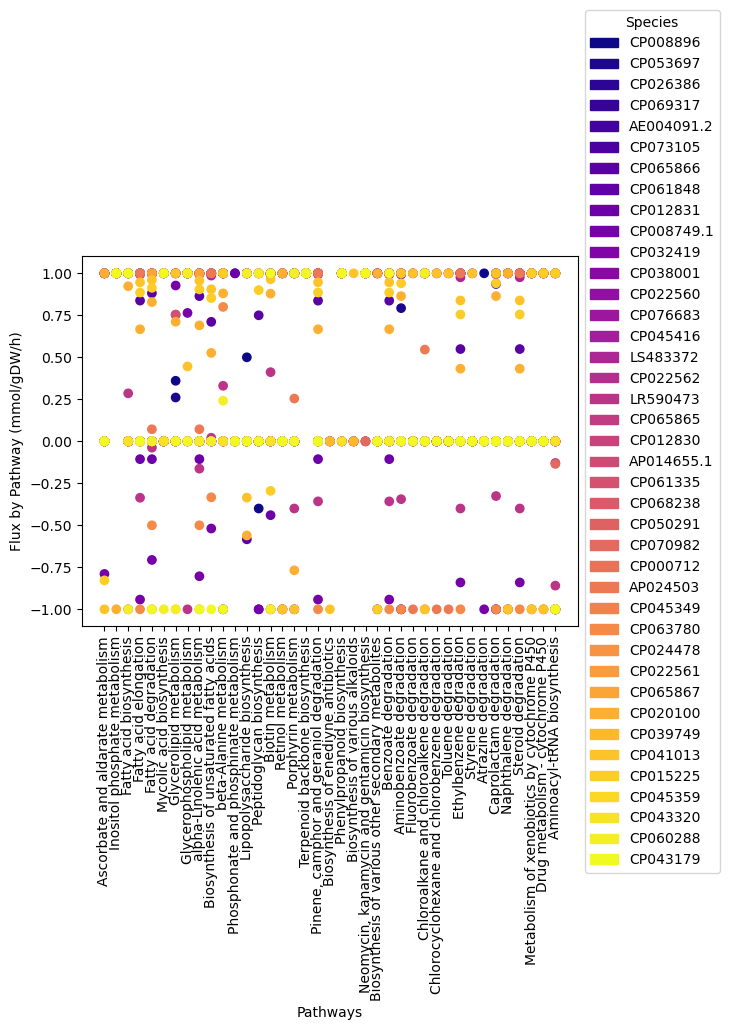

In [4]:
# plotting
pathways_df = pd.DataFrame(index = pathway_to_name.keys())

# let's loop through all of these to pull out flux_dfs
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
for f in os.listdir(os.path.join(base_dir, 'individual_species')):
    if 'Reference' in f: continue
    
    # look to see if solution already exists
    sol_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_solution.pkl')
    flux_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_solution_dict.pkl')
    if not os.path.exists(sol_path) or not os.path.exists(flux_path):
        print(str(f)+' : not yet run')
        continue
    
    # load in results
    pickle_in = open(sol_path, 'rb')
    sol = pickle.load(pickle_in)
    pickle_in.close()
    pickle_in = open(flux_path, 'rb')
    flux_df = pickle.load(pickle_in)
    pickle_in.close()
    if type(flux_df) == bool or len(flux_df) == 0:
        continue
    
    # reorganize by pathway groups
    pathway_to_fluxes = {}
    for index, row in flux_df.iterrows():
        pathways = row['pathways']
        for pathway in pathways:
            if pathway not in pathway_to_fluxes:
                pathway_to_fluxes.update({pathway : []})
            pathway_to_fluxes[pathway].append(row['flux'])
    
    # take max of each to represent the flux through the map (not sure what the best strategy is, maybe manually pick bottlenecks?)
    vals = []
    for pathway in pathways_df.index:
        if pathway in pathway_to_fluxes:
            # copying from https://www.nature.com/articles/s41467-020-17612-8
            total = sum(pathway_to_fluxes[pathway])
            abs_total = sum([abs(val) for val in pathway_to_fluxes[pathway]])
            if abs_total == 0:
                vals.append(0)
            else:
                vals.append(total / abs_total)
        else:
            vals.append(None)
    pathways_df[f] = vals


# now we can plot
pathways_df = pathways_df.dropna(0, how = 'all')
keep = pathways_df.index[abs(pathways_df).sum(axis = 1) != 0] # remove examples where all zero
pathways_df = pathways_df.loc[keep]
keep = pathways_df.index[abs(pathways_df).sum(axis = 1) != len(pathways_df.columns)] # remove examples of all 1s or all -1s
pathways_df = pathways_df.loc[keep]
keep = [any([val not in [-1, 0, 1] for val in vals]) for vals in pathways_df.values]
pathways_df = pathways_df.loc[keep]

colors = get_n_colors_from_colormap(len(pathways_df.columns), 'plasma')
col_to_colors = {col : color for col, color in zip(pathways_df.columns, colors)}
colors = []
x_vals = []
y_vals = []
labels = []
i = 0
for index in pathways_df.index:
    labels.append(pathway_to_name[index])
    for col in pathways_df.columns:
        val = pathways_df.loc[index][col]
        x_vals.append(i)
        y_vals.append(val)
        colors.append(col_to_colors[col])
    i += 1
plt.scatter(x_vals, y_vals, c = colors)
plt.xticks(np.arange(0, max(x_vals)+1), labels, rotation = 90)
plt.xlabel('Pathways')
plt.ylabel('Flux by Pathway (mmol/gDW/h)')

# Custom legend using patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in col_to_colors.items()]
plt.legend(handles=legend_patches, title='Species', loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.savefig(os.path.join(coralme_dir, 'figures', 'pathway_flux.pdf'), transparent = True)
plt.show()